In [1]:
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.utils as utils
import torch.nn.functional as F

from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision.utils import save_image

from torchvision.transforms import Compose, CenterCrop, Normalize, ToTensor
from pytorch_wavelets import DWT1DForward, DWT1DInverse  # or simply DWT1D, IDWT1D

from glob import glob

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

In [3]:
input = 1
numf =16

patch = 1
dim = 3072

batch_size = 64
test_size = 64

def Normalization(data):
    
    data_mean = data.mean()
    data_std = data.std()
    
    data = data - data_mean
    data = data / data_std
    
    return data

In [4]:
device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")
print(torch.cuda.is_available())

True


In [5]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, root):
        self.root = root  
        if not os.path.exists(self.root):
            raise Exception("[!] {} not exists.".format(root))
        
        #sort file names
        self.input_paths = sorted(glob(os.path.join(self.root, '{}/*.npy'.format("Train_Data/Data_Axle/7_Car_8_N/Train_data"))))
        self.label_paths = sorted(glob(os.path.join(self.root, '{}/*.npy'.format("Train_Data/Data_Axle/7_Car_8_N/Train_lab"))))
        self.name = os.path.basename(root)
        
        if len(self.input_paths) == 0 or len(self.label_paths) == 0:
            raise Exception("No signal/labels are found in {}".format(self.root))

    def __getitem__(self, index):
        
        Signal = np.load(self.input_paths[index])
        Signal = Normalization(Signal)
        Signal = Signal.reshape((patch, dim))
        
        label = np.load(self.label_paths[index])
        Label = label[1:3]
        #print(Label)
            
        return Signal, Label

    def __len__(self):
        return len(self.input_paths)


    
class Dataset_test(torch.utils.data.Dataset):
    def __init__(self, root):
        self.root = root
        
        if not os.path.exists(self.root):
            raise Exception("[!] {} not exists.".format(root))
        
        #sort file names
        self.input_paths = sorted(glob(os.path.join(self.root, '{}/*.npy'.format("Train_Data/Data_Axle/7_Car_8_N/Test_data"))))
        self.label_paths = sorted(glob(os.path.join(self.root, '{}/*.npy'.format("Train_Data/Data_Axle/7_Car_8_N/Test_lab"))))
        self.name = os.path.basename(root)
        
        #print(self.input_paths)
        #print(self.label_paths)
        
        if len(self.input_paths) == 0 or len(self.label_paths) == 0:
            raise Exception("No sinagl/labels are found in {}".format(self.root))

    def __getitem__(self, index):
        
        Signal = np.load(self.input_paths[index])
        Signal = Normalization(Signal)
        Signal = Signal.reshape((patch,dim))
        
        label = np.load(self.label_paths[index])
        Label = label[1:3]
        
        return Signal, Label

    def __len__(self):
        return len(self.input_paths)

In [6]:
def loader(dataset, batch_size, num_workers=0, shuffle = False, drop_last=False):

    input_images = dataset
    input_loader = torch.utils.data.DataLoader(dataset=input_images, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers, drop_last=drop_last)

    return input_loader

train_loader = loader(Dataset('../../'), batch_size= batch_size, shuffle = True, drop_last=True)
test_loader = loader(Dataset_test('../../'), batch_size= test_size, shuffle = True, drop_last=True)

In [8]:
input = 1
numf =12

class SConv_1D(nn.Module):
    '''(conv => BN => ReLU) * 2'''
    def __init__(self, in_ch, out_ch, kernel, pad):
        super(SConv_1D, self).__init__()
        
        self.conv = nn.Sequential(
            nn.Conv1d(in_ch, out_ch, kernel, padding=pad),
            nn.GroupNorm(6, out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        
        x = self.conv(x)
        return x


class WaveCNN_1D(nn.Module):
    def __init__(self):
        super(WaveCNN_1D, self).__init__()
        
        self.SConv1 = SConv_1D(input, numf, 5, 2)
        self.DWT1= DWT1DForward(J=3, wave='db12').cuda()
        self.dropout1 = nn.Dropout(p=0.1)
        
        self.SConv2 = SConv_1D(numf, numf*2, 5, 2)        
        self.pool2 = nn.MaxPool1d(4)
        self.DWT2= DWT1DForward(J=3, wave='db12').cuda() 
        self.dropout2 = nn.Dropout(p=0.1)
        
        
        self.SConv3 = SConv_1D(numf*2, numf*4, 5, 2)
        self.pool3 = nn.MaxPool1d(4)
        self.DWT3= DWT1DForward(J=3, wave='db12').cuda()       
        self.dropout3 = nn.Dropout(p=0.1)
        

        self.SConv4 = SConv_1D(numf*4, numf*8, 5, 2)
        self.pool4 = nn.MaxPool1d(4)
        self.DWT4= DWT1DForward(J=3, wave='db12').cuda()  
        self.dropout4 = nn.Dropout(p=0.1)
        
        
        self.SConv5 = SConv_1D(numf*8, numf*16, 5, 2) 
        self.pool5 = nn.MaxPool1d(2)
        self.DWT5= DWT1DForward(J=3, wave='db12').cuda()  
        self.dropout5 = nn.Dropout(p=0.1)
        
        self.SConv6 = SConv_1D(numf*16, numf*32, 5, 2)              
        
        self.avg_pool = nn.AdaptiveAvgPool1d((1))
        self.fc = nn.Linear(numf*32, 2)

        
    def forward(self, input):
        
        output = self.SConv1(input)
        DMT_yl1,DMT_yh1 = self.DWT1(output)
        output = torch.cat([DMT_yl1,DMT_yh1[2],DMT_yh1[1],DMT_yh1[0]], dim=2)
        output = self.dropout1(output)
        
        output = self.SConv2(output)
        output = self.pool2(output)
        DMT_yl2,DMT_yh2 = self.DWT2(output)
        output = torch.cat([DMT_yl2,DMT_yh2[2],DMT_yh2[1],DMT_yh2[0]], dim=2)
        output = self.dropout2(output)
        
        output = self.SConv3(output)
        output = self.pool3(output)        
        DMT_yl3,DMT_yh3 = self.DWT3(output)
        output = torch.cat([DMT_yl3,DMT_yh3[2],DMT_yh3[1],DMT_yh3[0]], dim=2)
        output = self.dropout3(output)
        
        output = self.SConv4(output)
        output = self.pool4(output)
        DMT_yl4,DMT_yh4 = self.DWT4(output)
        output = torch.cat([DMT_yl4,DMT_yh4[2],DMT_yh4[1],DMT_yh4[0]], dim=2)         
        output = self.dropout4(output)
        
        output = self.SConv5(output)
        output = self.pool5(output)
        DMT_yl5,DMT_yh5 = self.DWT5(output)
        output = torch.cat([DMT_yl5,DMT_yh5[2],DMT_yh5[1],DMT_yh5[0]], dim=2)    
        output = self.dropout5(output)
        
        output = self.SConv6(output)             
        #print(output.shape)    
        output = self.avg_pool(output)
        output = output.view(output.size(0), -1)
        output = self.fc(output)
        
        return output

In [9]:
Model = WaveCNN_1D().to(device)

print(Model)

print('# Model parameters:', sum(param.numel() for param in Model.parameters()))

WaveCNN_1D(
  (SConv1): SConv_1D(
    (conv): Sequential(
      (0): Conv1d(1, 12, kernel_size=(5,), stride=(1,), padding=(2,))
      (1): GroupNorm(6, 12, eps=1e-05, affine=True)
      (2): ReLU(inplace=True)
    )
  )
  (DWT1): DWT1DForward()
  (dropout1): Dropout(p=0.1, inplace=False)
  (SConv2): SConv_1D(
    (conv): Sequential(
      (0): Conv1d(12, 24, kernel_size=(5,), stride=(1,), padding=(2,))
      (1): GroupNorm(6, 24, eps=1e-05, affine=True)
      (2): ReLU(inplace=True)
    )
  )
  (pool2): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (DWT2): DWT1DForward()
  (dropout2): Dropout(p=0.1, inplace=False)
  (SConv3): SConv_1D(
    (conv): Sequential(
      (0): Conv1d(24, 48, kernel_size=(5,), stride=(1,), padding=(2,))
      (1): GroupNorm(6, 48, eps=1e-05, affine=True)
      (2): ReLU(inplace=True)
    )
  )
  (pool3): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (DWT3): DWT1DForward()
  (dropout3): Dropout(p=0.1

In [10]:
Criterion = nn.MSELoss()

Optimizer = torch.optim.Adam(Model.parameters(), lr=0.0001)


In [11]:
list = []
Train_list = []
Test_list = []

for epoch in range(250):
    
    run_loss = 0.0
    test_loss = 0.0

    train_i = 0
    test_i = 0
    
    for i_1, train_data in enumerate(train_loader):
        
        #print(i_1)
        inputs, labels = train_data
        
        inputs = inputs.type(torch.FloatTensor)
        inputs = inputs.to(device)
        
        labels = labels.type(torch.FloatTensor)
        labels = labels.to(device)
        
        Model.train()
        pre_labs = Model(inputs)
        Loss = Criterion(labels, pre_labs)

        Optimizer.zero_grad()
        Loss.backward()
        Optimizer.step()
        
        run_loss += Loss.item()
        train_i += 1
        
    for i_2, data in enumerate(test_loader):
        with torch.no_grad():

            test_data, test_lab = data  
            #test_data = test_data.unsqueeze(1)
            test_data = test_data.type(torch.FloatTensor)
            test_data = test_data.to(device)

            test_lab = test_lab.type(torch.FloatTensor)
            test_lab = test_lab.to(device)

            Model.eval()
            pre_labs = Model(test_data)
            Loss = Criterion(test_lab, pre_labs)

            test_loss += Loss    
            test_i += 1

    list.append(test_loss)
    print(test_i)

    if epoch >= 50:
        torch.save(Model, "model/2/CNN_%d.pkl"% epoch)
        print("-------保存第%d epoch的模型---------"% epoch)

    print('e: %d, train_loss: %.5f, test_loss: %.5f, ' % 
          (epoch, run_loss/train_i, test_loss/test_i))
    print('-----------------------------------------------')

    Train_list.append(run_loss/train_i)
    Test_list.append(test_loss/test_i)

print("Finished Training")

136
e: 0, train_loss: 0.03382, test_loss: 0.01873, 
-----------------------------------------------
136
e: 1, train_loss: 0.01460, test_loss: 0.01612, 
-----------------------------------------------
136
e: 2, train_loss: 0.01126, test_loss: 0.01514, 
-----------------------------------------------
136
e: 3, train_loss: 0.00986, test_loss: 0.01596, 
-----------------------------------------------
136
e: 4, train_loss: 0.00872, test_loss: 0.01408, 
-----------------------------------------------
136
e: 5, train_loss: 0.00812, test_loss: 0.01416, 
-----------------------------------------------
136
e: 6, train_loss: 0.00742, test_loss: 0.01470, 
-----------------------------------------------
136
e: 7, train_loss: 0.00691, test_loss: 0.01175, 
-----------------------------------------------
136
e: 8, train_loss: 0.00664, test_loss: 0.00919, 
-----------------------------------------------
136
e: 9, train_loss: 0.00634, test_loss: 0.00985, 
-----------------------------------------------


136
-------保存第74 epoch的模型---------
e: 74, train_loss: 0.00174, test_loss: 0.00465, 
-----------------------------------------------
136
-------保存第75 epoch的模型---------
e: 75, train_loss: 0.00172, test_loss: 0.00443, 
-----------------------------------------------
136
-------保存第76 epoch的模型---------
e: 76, train_loss: 0.00170, test_loss: 0.00402, 
-----------------------------------------------
136
-------保存第77 epoch的模型---------
e: 77, train_loss: 0.00168, test_loss: 0.00405, 
-----------------------------------------------
136
-------保存第78 epoch的模型---------
e: 78, train_loss: 0.00169, test_loss: 0.00382, 
-----------------------------------------------
136
-------保存第79 epoch的模型---------
e: 79, train_loss: 0.00168, test_loss: 0.00364, 
-----------------------------------------------
136
-------保存第80 epoch的模型---------
e: 80, train_loss: 0.00167, test_loss: 0.00402, 
-----------------------------------------------
136
-------保存第81 epoch的模型---------
e: 81, train_loss: 0.00167, test_loss: 0.

136
-------保存第136 epoch的模型---------
e: 136, train_loss: 0.00121, test_loss: 0.00364, 
-----------------------------------------------
136
-------保存第137 epoch的模型---------
e: 137, train_loss: 0.00119, test_loss: 0.00330, 
-----------------------------------------------
136
-------保存第138 epoch的模型---------
e: 138, train_loss: 0.00117, test_loss: 0.00452, 
-----------------------------------------------
136
-------保存第139 epoch的模型---------
e: 139, train_loss: 0.00121, test_loss: 0.00370, 
-----------------------------------------------
136
-------保存第140 epoch的模型---------
e: 140, train_loss: 0.00118, test_loss: 0.00494, 
-----------------------------------------------
136
-------保存第141 epoch的模型---------
e: 141, train_loss: 0.00118, test_loss: 0.00432, 
-----------------------------------------------
136
-------保存第142 epoch的模型---------
e: 142, train_loss: 0.00118, test_loss: 0.00392, 
-----------------------------------------------
136
-------保存第143 epoch的模型---------
e: 143, train_loss: 0.0011

136
-------保存第198 epoch的模型---------
e: 198, train_loss: 0.00096, test_loss: 0.00399, 
-----------------------------------------------
136
-------保存第199 epoch的模型---------
e: 199, train_loss: 0.00094, test_loss: 0.00409, 
-----------------------------------------------
136
-------保存第200 epoch的模型---------
e: 200, train_loss: 0.00093, test_loss: 0.00653, 
-----------------------------------------------
136
-------保存第201 epoch的模型---------
e: 201, train_loss: 0.00095, test_loss: 0.00442, 
-----------------------------------------------
136
-------保存第202 epoch的模型---------
e: 202, train_loss: 0.00094, test_loss: 0.00380, 
-----------------------------------------------
136
-------保存第203 epoch的模型---------
e: 203, train_loss: 0.00092, test_loss: 0.00364, 
-----------------------------------------------
136
-------保存第204 epoch的模型---------
e: 204, train_loss: 0.00096, test_loss: 0.00379, 
-----------------------------------------------
136
-------保存第205 epoch的模型---------
e: 205, train_loss: 0.0009

In [12]:
print("********Training_Loss*********")
P_train = [float('{:.8f}'.format(i)) for i in Train_list]
print(P_train)

T_lsit = np.zeros((250))
for id in range(250):
    T_lsit[id]=Test_list[id].cpu().detach().numpy()

T_lsit = T_lsit.tolist()
P_test = [float('{:.8f}'.format(i)) for i in T_lsit]
print("********Test_Loss*********")    
print(P_test)

********Training_Loss*********
[0.03381641, 0.01460477, 0.01125886, 0.00985731, 0.00872436, 0.00812099, 0.00742298, 0.00690772, 0.00663728, 0.00634168, 0.0059519, 0.00580406, 0.00554272, 0.00541906, 0.00512801, 0.00493438, 0.00484001, 0.00471805, 0.00446284, 0.0043735, 0.00426051, 0.00411631, 0.00398771, 0.0038874, 0.00373475, 0.00362011, 0.0034986, 0.00337377, 0.00328295, 0.00322016, 0.00309195, 0.00302699, 0.00299962, 0.00288801, 0.00282931, 0.00271532, 0.00272818, 0.00264252, 0.00259555, 0.00253031, 0.00250584, 0.00244223, 0.00241279, 0.00238851, 0.00237012, 0.00231861, 0.00227186, 0.00225585, 0.00222612, 0.00224124, 0.0021525, 0.0021354, 0.00213579, 0.00210565, 0.00211076, 0.00203972, 0.00201732, 0.00201462, 0.00198156, 0.00198901, 0.00194958, 0.00194644, 0.0019155, 0.00190687, 0.00189648, 0.00184789, 0.00183461, 0.00186593, 0.00183888, 0.00181415, 0.00177879, 0.00180664, 0.00176295, 0.00176277, 0.00174117, 0.00172284, 0.0016981, 0.00167572, 0.00169146, 0.00167772, 0.00167302, 0.00

In [34]:
from sklearn.metrics import mean_squared_error #均方误差
from sklearn.metrics import mean_absolute_error #平方绝对误差
from sklearn.metrics import r2_score #R square
#调用
#mean_squared_error(y_test,y_predict)
#mean_absolute_error(y_test,y_predict)
#r2_score(y_test,y_predict)
model_id = '2/CNN_238'

Test_car = '7_Car_8_N'
Image_save = '1DCNN_7_Car_8_N'

In [35]:
Test_i = 0
T_MSE_total = 0 
#T_RMSE_tptal = 0
T_MAE_total = 0
T_RScore_total = 0

F_MSE_total = 0 
#T_RMSE_tptal = 0
F_MAE_total = 0
F_RScore_total = 0


for i_2, data in enumerate(test_loader):

    test_data, test_lab = data  
    #test_data = test_data.unsqueeze(1)
    test_data = test_data.type(torch.FloatTensor)
    test_data = test_data.to(device)

    #test_lab = test_lab.type(torch.FloatTensor)
    #test_lab = test_lab.

    Model.eval()
    Model = torch.load('model/'+model_id+'.pkl')
    
    pre_labs = Model(test_data)
    pre_labs = pre_labs.cpu().detach().numpy()
    
    #print(pre_labs.shape)
    T_MSE = mean_squared_error(test_lab[:,0], pre_labs[:,0])
    T_MAE = mean_absolute_error(test_lab[:,0], pre_labs[:,0])
    T_RScore = r2_score(test_lab[:,0], pre_labs[:,0])
    
    F_MSE = mean_squared_error(test_lab[:,1], pre_labs[:,1])
    F_MAE = mean_absolute_error(test_lab[:,1], pre_labs[:,1])
    F_RScore = r2_score(test_lab[:,1], pre_labs[:,1])
    
    T_MSE_total += T_MSE
    T_MAE_total += T_MAE
    T_RScore_total += T_RScore
    
    F_MSE_total += F_MSE
    F_MAE_total += F_MAE
    F_RScore_total += F_RScore
    
    Test_i += 1

TM_MSE = T_MSE_total/Test_i
TM_RMSE = np.sqrt(TM_MSE)
TM_MAE = T_MAE_total/Test_i
TM_RScore = T_RScore_total/Test_i

FM_MSE = F_MSE_total/Test_i
FM_RMSE = np.sqrt(FM_MSE)
FM_MAE = F_MAE_total/Test_i
FM_RScore = F_RScore_total/Test_i

print('T_MSE: %.6f, T_RMSE: %.6f, T_MAE: %.6f, T_RScore: %.6f,' % (TM_MSE, TM_RMSE, TM_MAE, TM_RScore))
print('F_MSE: %.6f, F_RMSE: %.6f, F_MAE: %.6f, F_RScore: %.6f,' % (FM_MSE, FM_RMSE, FM_MAE, FM_RScore))

T_MSE: 0.001600, T_RMSE: 0.039996, T_MAE: 0.028672, T_RScore: 0.940058,
F_MSE: 0.005012, F_RMSE: 0.070796, F_MAE: 0.035122, F_RScore: 0.917441,


In [36]:
#T_MSE: 0.001620, T_RMSE: 0.040246, T_MAE: 0.027354, T_RScore: 0.940195,
#F_MSE: 0.004163, F_RMSE: 0.064524, F_MAE: 0.033637, F_RScore: 0.935673,

In [24]:
def Get_test_data(test_num, class_id, total_num):
    test_data = np.zeros((test_num, 1, 3072), dtype = np.float32)
    test_lab = np.zeros((test_num, 3), dtype = np.float32)
    
    list = random.sample(range(total_num), test_num)
    flag = 0
    
    for id in list:
        num_id = str(id)
        
        data = np.load("../../Train_Data/Data_Axle/"+Test_car+"/Test_detail/"+class_id+"/"+ num_id +"_test.npy")
        lab = np.load("../../Train_Data/Data_Axle/"+Test_car+"/Test_detail_lab/"+class_id+"/"+ num_id +"_lab.npy")
        data = Normalization(data)
        data = data.reshape((patch, dim))
                
        test_data[flag, :, :] = data
        test_lab[flag, :] = lab
        
        flag = flag + 1
        
    return test_data,test_lab

In [25]:
def get_rand_value(wear, lab, num, total_num):
    
    value = np.zeros((num), dtype = np.float32)
    X_value = np.zeros((num), dtype = np.float32)
    
    list = random.sample(range(total_num), num)
    flag = 0
    
    for id in list:
        
        value[flag] = wear[id]
        X_value[flag] = lab
        flag = flag+1
        
    return value, X_value

In [26]:
flag = 0
test_num = 400
total_num = 400
s_num = 50

Dis_X = np.zeros((18), dtype = np.float32)
T_lab = np.zeros((18), dtype = np.float32)
F_lab = np.zeros((18), dtype = np.float32)

T_Pre = np.zeros((18), dtype = np.float32)
F_Pre = np.zeros((18), dtype = np.float32)

T_Pre_scat = np.zeros((18*s_num), dtype = np.float32)
F_Pre_scat = np.zeros((18*s_num), dtype = np.float32)
X_scat = np.zeros((18*s_num), dtype = np.float32)

T_Pre_std = np.zeros((18), dtype = np.float32)
F_Pre_std = np.zeros((18), dtype = np.float32)


for id in range(18):

    id = id +1
    
    Model = torch.load('model/'+model_id+'.pkl')
    Model.eval()
    
    str_id = str(id)
    data_class,lab_class= Get_test_data(test_num, str_id, total_num)
    data_class = torch.from_numpy(data_class)
    data_class = data_class.to(device)
    pre_labs = Model(data_class)
    pre_labs = pre_labs.cpu().detach().numpy()

    T_wear = pre_labs[:,0]
    F_wear = pre_labs[:,1] 
    T_Pre_scat[flag*s_num:flag*s_num+s_num],X_scat[flag*s_num:flag*s_num+s_num] = get_rand_value(T_wear, lab_class[0][0], s_num, total_num)
    F_Pre_scat[flag*s_num:flag*s_num+s_num],X_scat[flag*s_num:flag*s_num+s_num] = get_rand_value(F_wear, lab_class[0][0], s_num, total_num)

    T_Pre[flag] = T_wear.mean()
    T_Pre_std[flag] = T_wear.std()
    F_Pre[flag] = F_wear.mean()
    F_Pre_std[flag] = F_wear.std()

    Dis_X[flag] = lab_class[0][0]
    T_lab[flag] = lab_class[0][1]
    F_lab[flag] = lab_class[0][2]
    #print(lab_class)

    flag = flag + 1
        

C:\Users\MSI-PC\anaconda3\envs\pytorch\lib\site-packages\IPython\core\interactiveshell.py:2878: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
C:\Users\MSI-PC\anaconda3\envs\pytorch\lib\site-packages\IPython\core\interactiveshell.py:2878: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
C:\Users\MSI-PC\anaconda3\envs\pytorch\lib\site-packages\IPython\core\interactiveshell.py:2878: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
C:\Users\MSI-PC\anaconda3\envs\pytorch\lib\site-packages\IPython\core\interactiveshell.py:2878: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


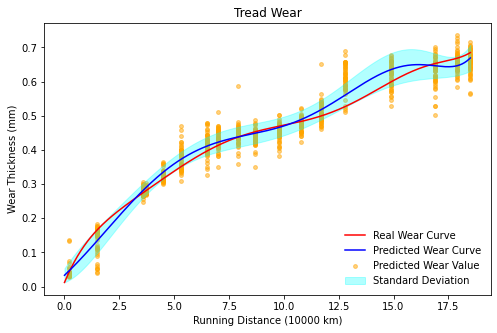

In [29]:
Wear_lab = np.polyfit(Dis_X, T_lab, 8)
Wear_pre = np.polyfit(Dis_X, T_Pre, 8)

Wear_pre_up = np.polyfit(Dis_X, (T_Pre+T_Pre_std), 8)
Wear_pre_down = np.polyfit(Dis_X, (T_Pre-T_Pre_std), 8)

P_Wear_lab = np.poly1d(Wear_lab)
P_Wear_pre = np.poly1d(Wear_pre)
P_Wear_up = np.poly1d(Wear_pre_up)
P_Wear_down = np.poly1d(Wear_pre_down)

X = np.linspace(0, 18.5, 500)

lab_curve = P_Wear_lab(X)
pre_curve = P_Wear_pre(X)
up_curve = P_Wear_up(X)
down_curve = P_Wear_down(X)


fig = plt.figure(figsize=[8,5])
sub = fig.add_subplot(111)

sub.plot(X, lab_curve, c='r', label='Real Wear Curve')

sub.scatter(X_scat , T_Pre_scat , s=15, c='orange', alpha=0.5, label='Predicted Wear Value')

sub.plot(X, pre_curve, c='blue', label='Predicted Wear Curve')

sub.fill_between(X, up_curve, down_curve, color='aqua', alpha=0.3, label='Standard Deviation')

plt.legend(loc=4, edgecolor='w')
plt.ylabel('Wear Thickness (mm)')
plt.xlabel('Running Distance (10000 km)')
plt.title('Tread Wear')

plt.show()
#fig.savefig('Image/'+Image_save+'_Tread.png', dpi=400)

C:\Users\MSI-PC\anaconda3\envs\pytorch\lib\site-packages\IPython\core\interactiveshell.py:2878: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
C:\Users\MSI-PC\anaconda3\envs\pytorch\lib\site-packages\IPython\core\interactiveshell.py:2878: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
C:\Users\MSI-PC\anaconda3\envs\pytorch\lib\site-packages\IPython\core\interactiveshell.py:2878: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
C:\Users\MSI-PC\anaconda3\envs\pytorch\lib\site-packages\IPython\core\interactiveshell.py:2878: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


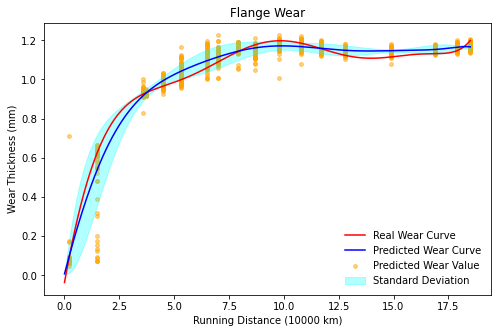

In [30]:
Wear_lab = np.polyfit(Dis_X, F_lab, 12)
Wear_pre = np.polyfit(Dis_X, F_Pre, 12)

Wear_pre_up = np.polyfit(Dis_X, (F_Pre+F_Pre_std), 12)
Wear_pre_down = np.polyfit(Dis_X, (F_Pre-F_Pre_std), 12)

P_Wear_lab = np.poly1d(Wear_lab)
P_Wear_pre = np.poly1d(Wear_pre)
P_Wear_up = np.poly1d(Wear_pre_up)
P_Wear_down = np.poly1d(Wear_pre_down)

X = np.linspace(0, 18.5, 500)

lab_curve = P_Wear_lab(X)
pre_curve = P_Wear_pre(X)
up_curve = P_Wear_up(X)
down_curve = P_Wear_down(X)


fig = plt.figure(figsize=[8,5])
sub = fig.add_subplot(111)

sub.plot(X, lab_curve, c='r', label='Real Wear Curve')

sub.scatter(X_scat , F_Pre_scat , s=15, c='orange', alpha=0.5, label='Predicted Wear Value')

sub.plot(X, pre_curve, c='blue', label='Predicted Wear Curve')

sub.fill_between(X, up_curve, down_curve, color='aqua', alpha=0.3, label='Standard Deviation')

plt.legend(loc=4, edgecolor='w')
plt.ylabel('Wear Thickness (mm)')
plt.xlabel('Running Distance (10000 km)')
plt.title('Flange Wear')

plt.show()
#fig.savefig('Image/'+Image_save+'_Flange.png', dpi=400)